# 1) Imports

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from os import walk
from os.path import join, exists
from utils import nomes, save_dataframe_as_feather, decode_rle

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering

import tensorflow
from tensorflow.keras.preprocessing import image

# 2) Carregar dataset

In [6]:
dataset = pd.read_feather('train_com_imagens.feather')
dataset = dataset.sample(frac=1)
dataset

,id,class,segmentation,image,width,height
67166,case90_day22_slice_0113,stomach,None,.\train\case90\case90_day22\scans\slice_0113_2...,266,266
50226,case117_day0_slice_0104,small_bowel,21698 3 21961 11 22221 29 22486 34 22751 40 23...,.\train\case117\case117_day0\scans\slice_0104_...,266,266
90246,case89_day20_slice_0140,stomach,None,.\train\case89\case89_day20\scans\slice_0140_2...,266,266
30163,case6_day0_slice_0086,large_bowel,22167 8 22525 12 22883 16 23197 16 23235 25 23...,.\train\case6\case6_day0\scans\slice_0086_360_...,360,310
67615,case144_day14_slice_0092,large_bowel,25096 5 25360 18 25624 20 25888 22 26152 24 26...,.\train\case144\case144_day14\scans\slice_0092...,266,266
...,...,...,...,...,...,...
22579,case125_day15_slice_0073,stomach,19837 10 20100 16 20357 27 20622 30 20887 33 2...,.\train\case125\case125_day15\scans\slice_0073...,266,266
30467,case119_day25_slice_0065,large_bowel,None,.\train\case119\case119_day25\scans\slice_0065...,266,266
76291,case134_day22_slice_0083,large_bowel,30421 7 30779 12 31137 15 31166 23 31495 18 31...,.\train\case134\case134_day22\scans\slice_0083...,360,310
74127,case122_day25_slice_0043,large_bowel,None,.\train\case122\case122_day25\scans\slice_0043...,266,266


# 3) Clusterizar imagens p/ gerar exemplos de teste

In [7]:
distancia_vizinho = 1
n_vizinhos = 25

def new_cluster_model():
	# Demora menos mas consumo de memória é n
	# return DBSCAN(
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	return KMeans(
		n_clusters=10,
	)

	# Demora consideravelmente mas não consome tanta memória
	# return OPTICS(
	# 	cluster_method='dbscan',
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	# Demora + consumo de memória
	# return AgglomerativeClustering(
	# 	n_clusters=10,
	# )

In [197]:
# largura, altura = 100, 100


class Counter:
    _count = 0
    @staticmethod
    def get():
        Counter._count += 1
        return Counter._count
    
    @staticmethod
    def reset():
        Counter._count = 0


cluster_model = new_cluster_model()

def clustering(linha):
    img = image.load_img(
        linha['image'],
        target_size=(linha['height'], linha['width']),
        color_mode='grayscale'
    )

    # Para realizar o clustering de uma imagem
    # Precisa de uma matriz das posicoes + uma dimensao para cores
    image_as_arr = image.img_to_array(img).reshape(linha['width'] * linha['height'], 1)

    print(Counter.get(), end=', ')
    
    return cluster_model.fit_predict(image_as_arr)

In [198]:
# Limitar os dados por questão de tempo
# limite_dados = 10000
# limite_dados = 1000
# limite_dados = 100
limite_dados = 25

df_dados = pd.concat([
	dataset[dataset['class'] == 'stomach'].sample(limite_dados),
	dataset[dataset['class'] == 'small_bowel'].sample(limite_dados),
	dataset[dataset['class'] == 'large_bowel'].sample(limite_dados),
])

df_dados['class'].value_counts()

df_dados['clusters'] = df_dados.apply(clustering, axis=1)
df_dados.head()

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 

,id,class,segmentation,image,width,height,clusters
69750,case65_day25_slice_0013,stomach,None,.\train\case65\case65_day25\scans\slice_0013_2...,266,266,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
112112,case121_day0_slice_0036,stomach,None,.\train\case121\case121_day0\scans\slice_0036_...,266,266,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
20371,case55_day20_slice_0044,stomach,None,.\train\case55\case55_day20\scans\slice_0044_2...,266,266,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
62921,case77_day0_slice_0095,stomach,22964 7 23228 11 23492 14 23757 16 24022 17 24...,.\train\case77\case77_day0\scans\slice_0095_26...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9898,case138_day0_slice_0014,stomach,None,.\train\case138\case138_day0\scans\slice_0014_...,266,266,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."


## Visualização

Número clusters: 9
Tem segmentação: True
(266, 266) (266, 266)


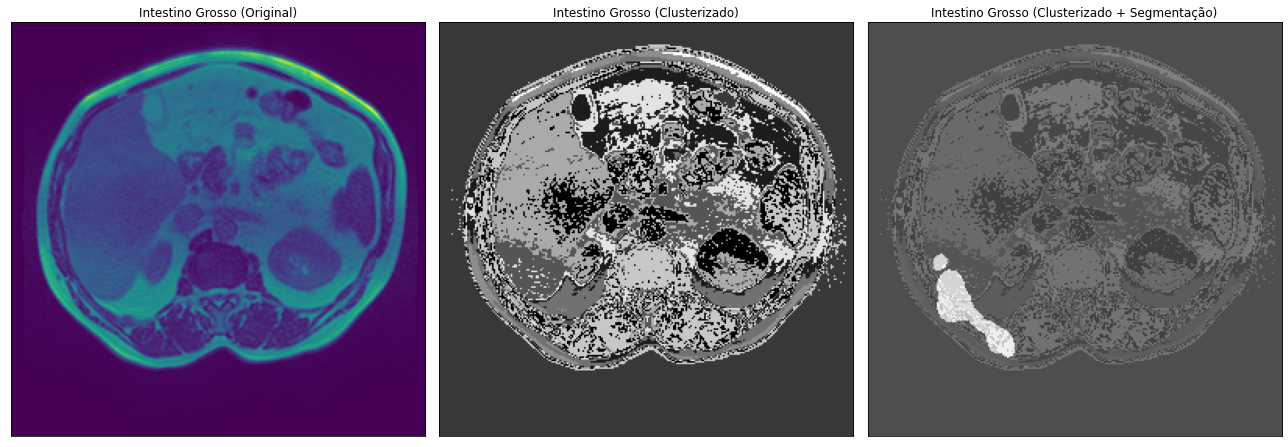

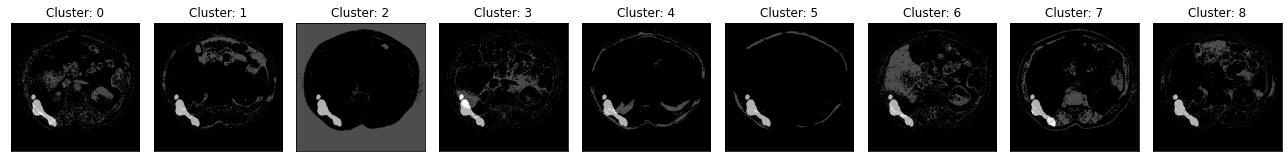

In [232]:
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]

print('Número clusters:', max(linha['clusters']))
print('Tem segmentação:', bool(linha['segmentation']))

# Desenhar
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)

ax = plt.subplot(1, 3, 1)
# ax.imshow(image.load_img(linha['image'], target_size=(linha['height'], linha['width'])))
ax.imshow(plt.imread(linha['image']))
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Original)')

ax = plt.subplot(1, 3, 2)
clusters = linha['clusters'].reshape(linha['height'], linha['width'])
ax.imshow(clusters, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Clusterizado)')
plt.tight_layout()

if linha['segmentation']:
	ax = plt.subplot(1, 3, 3)

	ax.imshow(clusters, cmap='gray', alpha=0.5)

	segmentation = linha['segmentation']
	segmentation_rle = decode_rle(segmentation, shape=(linha['height'], linha['width']))

	# if clusters.shape[0] != segmentation_rle.shape[0] and clusters.shape[1] != segmentation_rle.shape[1]:
	# 	print('>', clusters.shape, segmentation_rle.shape)
	# 	segmentation_rle = segmentation_rle.reshape(clusters.shape[0], clusters.shape[1])

	print(clusters.shape, segmentation_rle.shape)
	ax.imshow(segmentation_rle, cmap='gray', alpha=0.5)
	plt.xticks([])
	plt.yticks([])
	plt.title(nomes[linha['class']] + ' (Clusterizado + Segmentação)')

	plt.tight_layout()

plt.show()

max_clusters = min(max(linha['clusters']), 50)
fig, axs = plt.subplots(1, max_clusters, figsize=(max_clusters * 2, 6))
fig.patch.set_alpha(1)
for i in range(max_clusters):
	cluster_selecionado = i
	d = pd.DataFrame(linha['clusters']).applymap(lambda x: 1 if x == cluster_selecionado else 0)
	d = np.array(d.values).reshape(linha['height'], linha['width'])
	axs[i].imshow(d, cmap='gray')
	axs[i].imshow(segmentation_rle, cmap='gray', alpha=0.7)
	axs[i].set_title(f'Cluster: {cluster_selecionado}')
	axs[i].set_xticks([])
	axs[i].set_yticks([])

plt.tight_layout()

# plt.title(nomes[linha['class']] + ' (Segmentado)')
# plt.show()

In [ ]:
# save_dataframe_as_feather(df_dados, 'train_imagens_clusters.feather')